In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:00<00:00, 566MB/s] 


In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [6]:
train_data_dir = "cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "cats-and-dogs-for-classification/cats_dogs/test"

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    subset="training",
    validation_split=0.1,
    seed=42
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    subset="validation",
    validation_split=0.1,
    seed=42
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
print(class_names)

['cats', 'dogs']


In [9]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


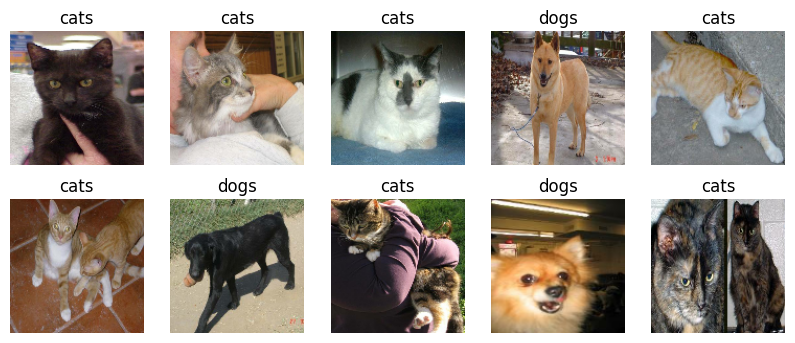

In [17]:
# plot some images
plt.figure(figsize=(10, 4))
for image, label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

## data preprocessing

In [18]:
for image,label in train_data.take(1):
    for i in range(1):
        print(image)

tf.Tensor(
[[[[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]]

  ...

  [[255.        255.        255.       ]
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   ...
   [255.        255.        255.       ]
   [255.        255.        255.       ]
   [2

In [19]:
# Normalization layer
train_data = train_data.map(lambda x, y: (x / 255.0, y))
validation_data = validation_data.map(lambda x, y: (x / 255.0, y))
test_data = test_data.map(lambda x, y: (x / 255.0, y))

In [20]:
for image,label in train_data.take(1):
    for i in range(1):
        print(image)

tf.Tensor(
[[[[0.27993643 0.2720933  0.31523055]
   [0.28791934 0.28345588 0.33274645]
   [0.26288584 0.2646446  0.3180511 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  [[0.2783701  0.27052698 0.32150736]
   [0.2989995  0.29898706 0.34615216]
   [0.26747665 0.27531978 0.3291188 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  [[0.33783126 0.33740234 0.38531902]
   [0.29682714 0.29435605 0.34877452]
   [0.28149894 0.29075137 0.3445504 ]
   ...
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]
   [0.09411765 0.03921569 0.00392157]]

  ...

  [[0.7763299  0.7449573  0.7880946 ]
   [0.7772059  0.7459559  0.78903186]
   [0.76164407 0.7418802  0.7826593 ]
   ...
   [0.26641965 0.21151769 0.19975299]
   [0.26668677 0.21178481 0.2000201 ]
   [0.2668074  0.21190545 0.20014074]]

  [[0.7670343  0.7435049  0.782720

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
